In [42]:
import geopandas as gpd
import sumolib
import osmnx as ox
from shapely import geometry
import networkx as nx
from shapely import wkt

In [43]:
# read the buildings 
bld = gpd.read_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/resid_centr_mc.geojson')
print(bld.crs)
print(bld.shape)

# parse the net
net = sumolib.net.readNet('C:/Users/barguzin/Documents/Github/rwmp_pipelines/study_area.net.xml')

epsg:4326
(1282, 6)


In [44]:
all_dist = []
all_edges = []
all_ids = []

lng, lat = bld.geometry.x, bld.geometry.y 

radius=50 # meters

xlon, xlat = net.convertLonLat2XY(lng, lat)

for x,y in zip(xlon, xlat): 
    edges = net.getNeighboringEdges(x, y, radius)

    if len(edges) > 0: 
        distancesAndEdges = sorted([(dist, edge) for edge, dist in edges], key=lambda x: x[0])
        dist, closestEdge = distancesAndEdges[0]

        all_dist.append(dist)
        all_edges.append(closestEdge)
        all_ids.append(closestEdge.getID())

In [45]:
print(bld.shape)
print(len(all_dist))
print(len(all_edges))

(1282, 6)
1242
1242


In [46]:
print(all_edges[:5])

[<edge id="-16262970#1" from="165437782" to="165476353"/>, <edge id="-678722520" from="6355141679" to="6355141889"/>, <edge id="-679909983#0" from="6366185189" to="6366185191"/>, <edge id="-679909981" from="6366185189" to="6366184872"/>, <edge id="16253433#2" from="566126288" to="6355141622"/>]


In [47]:
print(closestEdge)
closestEdge.getID()

<edge id="924683558" from="8581835023" to="8581835028"/>


'924683558'

In [48]:
import pandas as pd

df = pd.DataFrame(list(zip(all_ids, all_dist, all_edges)), columns=['id', 'dist', 'from_to'])
df

,id,dist,from_to
0,-16262970#1,16.347742,"<edge id=""-16262970#1"" from=""165437782"" to=""16..."
1,-678722520,11.383053,"<edge id=""-678722520"" from=""6355141679"" to=""63..."
2,-679909983#0,10.340639,"<edge id=""-679909983#0"" from=""6366185189"" to=""..."
3,-679909981,7.984477,"<edge id=""-679909981"" from=""6366185189"" to=""63..."
4,16253433#2,22.724856,"<edge id=""16253433#2"" from=""566126288"" to=""635..."
...,...,...,...
1237,924683558,8.126412,"<edge id=""924683558"" from=""8581835023"" to=""858..."
1238,-886568238#1,37.294320,"<edge id=""-886568238#1"" from=""8563538342"" to=""..."
1239,-627887422#3,36.524892,"<edge id=""-627887422#3"" from=""165621894"" to=""1..."
1240,-922463717,20.488067,"<edge id=""-922463717"" from=""8563538343"" to=""85..."


In [49]:
# to generate traffic from OD in SUMO 
# Prep inputs: TAZ and OD cost matrix

# TAZ
# 1. import shapes (primary highways buffer) via 'polyconvert' tool (These are TAZs)
# 2. assign edges to TAZ () via 'edgesInDistrict.py'

# OD 
# 1. create routes 

In [50]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# draw a sample from Poisson distribution
pois = np.random.poisson(lam = (1, 2, 3), size=(100,3))

# draw a sample from Gaussian distribution
mu, sd = (12,12,12), (1,2,3)
#norm = np.random.normal(loc = (12,12,12), scale = (1,2,5), size=(100,3))
norm = np.random.normal(loc = mu, scale = sd, size=(100,3))

print(pois.shape)
print(norm.shape)

(100, 3)
(100, 3)


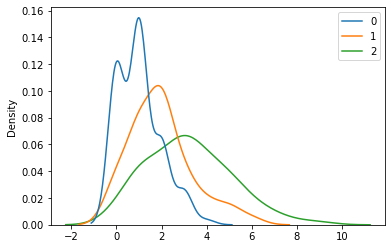

In [51]:
sns.kdeplot(pois)

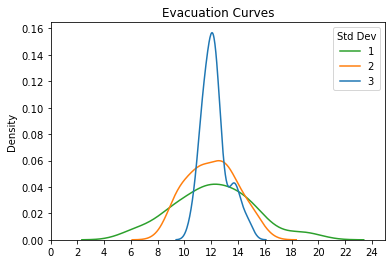

In [52]:
# generate normal distribution for 24 hours (15 minutes intervals) 
# mean is always around 3pm, st dev changes as seen below 
g = sns.kdeplot(norm, legend=False, )

plt.title('Evacuation Curves')
plt.legend(title='Std Dev', labels=sd)
plt.xlim(0,25)
plt.xticks(np.arange(0,25,2));


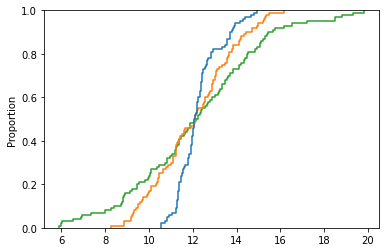

In [53]:
# this is the so-called evacation S-curve
g = sns.ecdfplot(norm, legend=False)

In [54]:
# add osm_id nodes associated with network origins for routing 
bld.head()

,osm_id,code,fclass,name,type,geometry
0,470719675,1500,building,None,house,POINT (-119.71771 34.45016)
1,678722521,1500,building,None,house,POINT (-119.71402 34.46445)
2,547734144,1500,building,None,house,POINT (-119.70888 34.46446)
3,679909982,1500,building,None,None,POINT (-119.70529 34.46452)
4,547723813,1500,building,None,house,POINT (-119.71085 34.46454)


In [55]:
minx, miny, maxx, maxy = bld.geometry.total_bounds
box = geometry.box(minx, miny, maxx, maxy)

G = ox.graph_from_polygon(box, network_type="drive_service") # include drive and service roads
Gp = ox.project_graph(G)

In [56]:
nodes, edges = ox.graph_to_gdfs(Gp)
exits = edges.loc[(edges.highway=='primary')|(edges.highway=='secondary')|(edges.highway=='motorway')|(edges.highway=='trunk')]

exits.head()

osmid           name    highway  oneway  \
u         v          key                                                
165552674 165319554  0    627887423  Foothill Road  secondary   False   
          9800659437 0    627887423  Foothill Road  secondary   False   
165319554 165524909  0    627887423  Foothill Road  secondary   False   
          165552674  0    627887423  Foothill Road  secondary   False   
165524909 165319554  0    627887423  Foothill Road  secondary   False   

                         reversed   length  \
u         v          key                     
165552674 165319554  0      False  341.423   
          9800659437 0       True  143.742   
165319554 165524909  0      False  241.134   
          165552674  0       True  341.423   
165524909 165319554  0       True  241.134   

                                                                   geometry  \
u         v          key                                                      
165552674 165319554  0    LINESTRING (249670.806 3815065.045, 249614.062...   
          9800659437 0    LINESTRING (249670.806 3815065.045, 249678.740...   
165319554 165524909  0    LINESTRING (249357.079 3815201.393, 249305.829...   
          165552674  0    LINESTRING (249357.079 3815201.393, 249614.062...   
165524909 165319554  0    LINESTRING (249133.010 3815291.538, 249140.111...   

                         access maxspeed lanes     ref service bridge  
u         v          key                                               
165552674 165319554  0      NaN   35 mph     2  CA 192     NaN    NaN  
          9800659437 0      NaN   35 mph     2  CA 192     NaN    NaN  
165319554 165524909  0      NaN   35 mph     2  CA 192     NaN    NaN  
          165552674  0      NaN   35 mph     2  CA 192     NaN    NaN  
165524909 165319554  0      NaN   35 mph     2  CA 192     NaN    NaN

In [57]:
# define speed for different road types 
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60, "primary": 90, "motorway": 90}

# impute speed on all edges missing data
Gp = ox.add_edge_speeds(Gp, hwy_speeds)

# calculate travel time (seconds) for all edges
Gp = ox.add_edge_travel_times(Gp)

In [58]:
# get projection
s = Gp.graph['crs'].to_epsg()

# reproject inputs 
bld_utm = bld.to_crs(f"EPSG:{s}")
exits_utm = exits.to_crs(f"EPSG:{s}")

# find each nearest node to several points, and optionally return distance
bnodes, bdists = ox.nearest_nodes(Gp, bld_utm.geometry.x, bld_utm.geometry.y, return_dist=True)
enodes, edists = ox.nearest_nodes(Gp, exits_utm.geometry.centroid.x, exits_utm.geometry.centroid.y, return_dist=True)

In [59]:
print('number of buildings', bld.shape[0])
print('number of closest nodes to bld', len(bnodes))
print('number of exits', exits_utm.shape[0])
print('number of closest nodes to exits', len(enodes))

number of buildings 1282
number of closest nodes to bld 1282
number of exits 28
number of closest nodes to exits 28


In [60]:
# see mean speed/time values by road type
edges2 = ox.graph_to_gdfs(Gp, nodes=False)
edges2["highway"] = edges2["highway"].astype(str)
edges2.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['service', 'residential']",379.7,65.0,21.0
residential,161.6,35.2,16.6
secondary,153.2,56.3,9.8
service,113.0,65.0,6.3


In [61]:
print(type(Gp))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [62]:
missing_nodes = list(set(Gp.nodes) - set(bnodes))
print(len(missing_nodes))

34


In [63]:
# this returned the same amount of nodes as original buildings
not_on_network2 = [x for x in bnodes if x not in Gp.nodes]
print(len(not_on_network2))

0


In [64]:
# this returned the same amount of nodes as original buildings
not_on_network = [x for x in enodes if x not in Gp.nodes]
print(len(not_on_network))

0


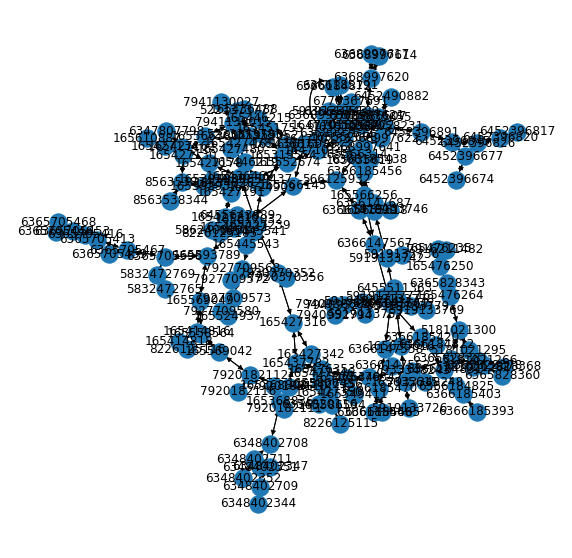

In [65]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(Gp, with_labels=True)

In [66]:
spath = nx.shortest_path(Gp, weight='travel_time')
sdist = dict(nx.shortest_path_length(Gp, weight='travel_time'))

#spath = nx.shortest_path(Gp)
#sdist = dict(nx.shortest_path_length(Gp))

In [67]:
sdist

{164710144: {164710144: 0,
  165552678: 8.0,
  165552674: 8.5,
  165436671: 13.4,
  9800659437: 17.7,
  165340262: 21.7,
  165319554: 30.3,
  164710153: 34.3,
  165392937: 37.7,
  165319552: 39.4,
  164710155: 39.699999999999996,
  165552722: 40.3,
  165319558: 40.9,
  165524909: 45.7,
  3775886507: 46.8,
  165392939: 47.5,
  165446215: 48.0,
  165319550: 50.099999999999994,
  165427191: 50.2,
  165445541: 50.300000000000004,
  165446219: 55.5,
  8563538342: 55.6,
  165427178: 58.0,
  8563538344: 58.9,
  165427478: 64.1,
  165445543: 64.4,
  165427130: 66.8,
  165436469: 67.0,
  165427480: 68.2,
  165427216: 71.0,
  165427134: 71.89999999999999,
  165427162: 73.4,
  165566380: 75.0,
  165427222: 75.2,
  6347807798: 75.5,
  5862400001: 75.6,
  7941130015: 79.6,
  8226125105: 80.4,
  7927709568: 81.80000000000001,
  7927709573: 82.60000000000001,
  165427239: 83.8,
  7927709572: 85.4,
  165524937: 85.4,
  7941130027: 86.3,
  165451755: 86.6,
  5223373783: 87.6,
  7927709580: 88.7,
  1656

148.9


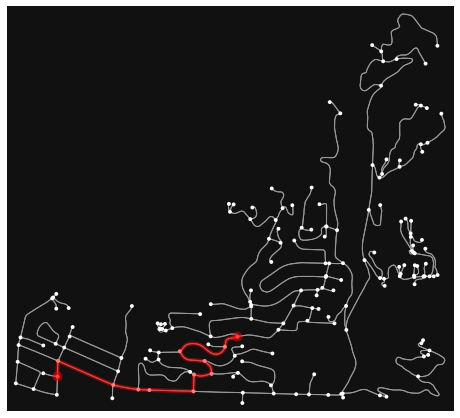

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2401759a0a0>)

In [68]:
route1 = spath[bnodes[0]][enodes[0]]
route1_length = sdist[bnodes[0]][enodes[0]]

print(route1_length)
ox.plot_graph_route(Gp, route1)

In [69]:
# to generate traffic from OD in SUMO 
# Prep inputs: TAZ and OD cost matrix

# TAZ
# 1. import shapes (primary highways buffer) via 'polyconvert' tool (These are TAZs)
# 2. assign edges to TAZ () via 'edgesInDistrict.py'

# OD 
# 1. create routes 

In [70]:
exits.crs

<Derived Projected CRS: +proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

EPSG:4326


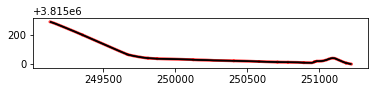

In [71]:
# create buffer around exits and save to file 
fig,ax=plt.subplots()

buff = exits_utm.buffer(10)
buff = buff.to_crs('EPSG:4326')
print(buff.crs)

buff.reset_index(inplace=True, drop=True)

buff = gpd.GeoDataFrame(geometry=buff)

buff = buff.dissolve()

buff.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/exit_taz.shp')

# there are 
buff_utm = buff.to_crs('EPSG:32611')
buff_utm.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/exit_taz_utm.shp')

exits_utm.buffer(10).plot(color='r', alpha=.5,ax=ax)
exits_utm.plot(color='k',ax=ax)

In [72]:
buff

,geometry
0,"POLYGON ((-119.71698 34.44666, -119.71697 34.4..."


EPSG:4326


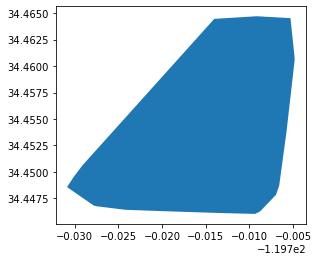

In [73]:
# create buffer around resid buiildings 
mpt = geometry.MultiPoint([geometry.shape(p) for p in bld['geometry']])
geom = mpt.convex_hull.wkt

d = {'geoid': 1, 'name': 'TAZ_destination'}
df = pd.DataFrame(d, index=[0])

df['wktext'] = geom
df['geometry'] = df.wktext.apply(wkt.loads)

df.drop('wktext', axis=1, inplace=True)

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

print(gdf.crs)

#gdf.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/bld_taz.geojson')
#gdf.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/bld_taz.shp')

gdf.plot()

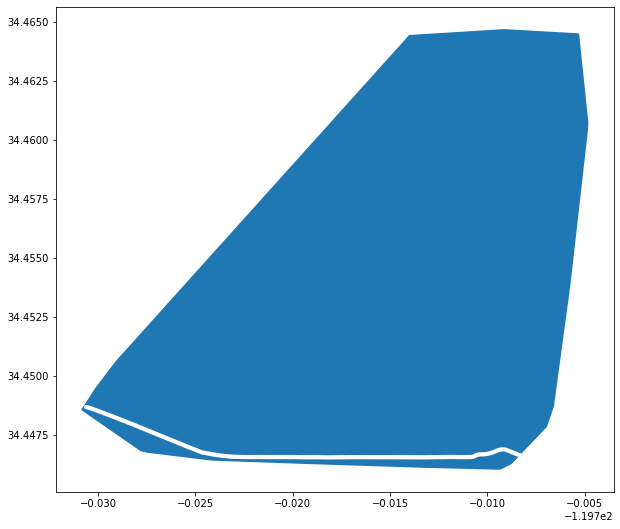

In [79]:
# modifying buildings taz 
fig, ax = plt.subplots(figsize=(10,10))

diff = gdf.geometry.difference(buff)

diff.plot(ax=ax)
#buff.plot(ax=ax)

diff.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/bld_taz.shp')

In [81]:
# combine two files into one shapefile and save it as TAZ
merged = diff.union(buff)
print(type(merged))

<class 'geopandas.geoseries.GeoSeries'>


0    POLYGON ((-119.71954 34.44629, -119.72406 34.4...
dtype: geometry

In [111]:
new_taz = gpd.GeoDataFrame(geometry = pd.concat([buff.geometry, diff.geometry])).reset_index()

new_taz
#new_taz.rename(columns={'index': 'TAZ_ID'}, inplace=True)

,index,geometry
0,0,"POLYGON ((-119.71698 34.44666, -119.71697 34.4..."
1,0,"POLYGON ((-119.71317 34.44612, -119.71954 34.4..."


<class 'geopandas.geodataframe.GeoDataFrame'>
                                            geometry  TAZ_ID
0  POLYGON ((-119.71698 34.44666, -119.71697 34.4...       1
1  POLYGON ((-119.71317 34.44612, -119.71954 34.4...       2


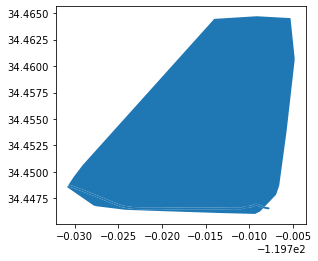

In [112]:
new_taz['TAZ_ID'] = 0
new_taz.at[0, 'TAZ_ID'] = 1
new_taz.at[1, 'TAZ_ID'] = 2

new_taz.drop('index', axis=1, inplace=True)

print(type(new_taz))
print(new_taz.head())
new_taz.plot()

In [113]:
new_taz.to_file('C:/Users/barguzin/Documents/Github/rwmp_pipelines/merged_taz.shp')

Value error


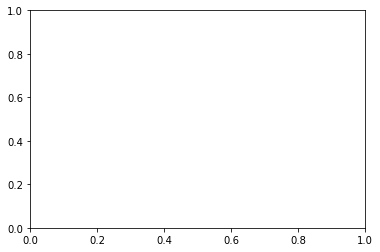

In [118]:
# plot originally downloaded network file 
import SumoNetVis
import matplotlib.pyplot as plt

net = SumoNetVis.Net("C:/Users/barguzin/Documents/Github/rwmp_pipelines/study_area.osm.xml")

try: 
  net.plot()
except ValueError:
  print('Value error')
  pass